<a href="https://colab.research.google.com/github/ryzwann/Klasifikasi_Topi-ResNet-50/blob/main/Klasifikasi_Topi_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧢 Topi Classification using ResNet50
Klasifikasi Topi Berdasarkan 4 kelas menggunakan ResNet50

In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/MyDrive/Dataset_Topi"  # sesuaikan dengan lokasi di GDrive kamu
transform = transforms.Compose

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = full_dataset.classes
print("Classes:", class_names)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes: ['Topi Baseball', 'Topi Kupluk', 'Topi Rimba', 'Topi Snapback']


In [3]:

paths, labels = [], []
for path, label in full_dataset.imgs:
    paths.append(path)
    labels.append(full_dataset.classes[label])
df = pd.DataFrame({'image_path': paths, 'label': labels})
df.head()


,image_path,label
0,/content/drive/MyDrive/Dataset_Topi/Topi Baseb...,Topi Baseball
1,/content/drive/MyDrive/Dataset_Topi/Topi Baseb...,Topi Baseball
2,/content/drive/MyDrive/Dataset_Topi/Topi Baseb...,Topi Baseball
3,/content/drive/MyDrive/Dataset_Topi/Topi Baseb...,Topi Baseball
4,/content/drive/MyDrive/Dataset_Topi/Topi Baseb...,Topi Baseball


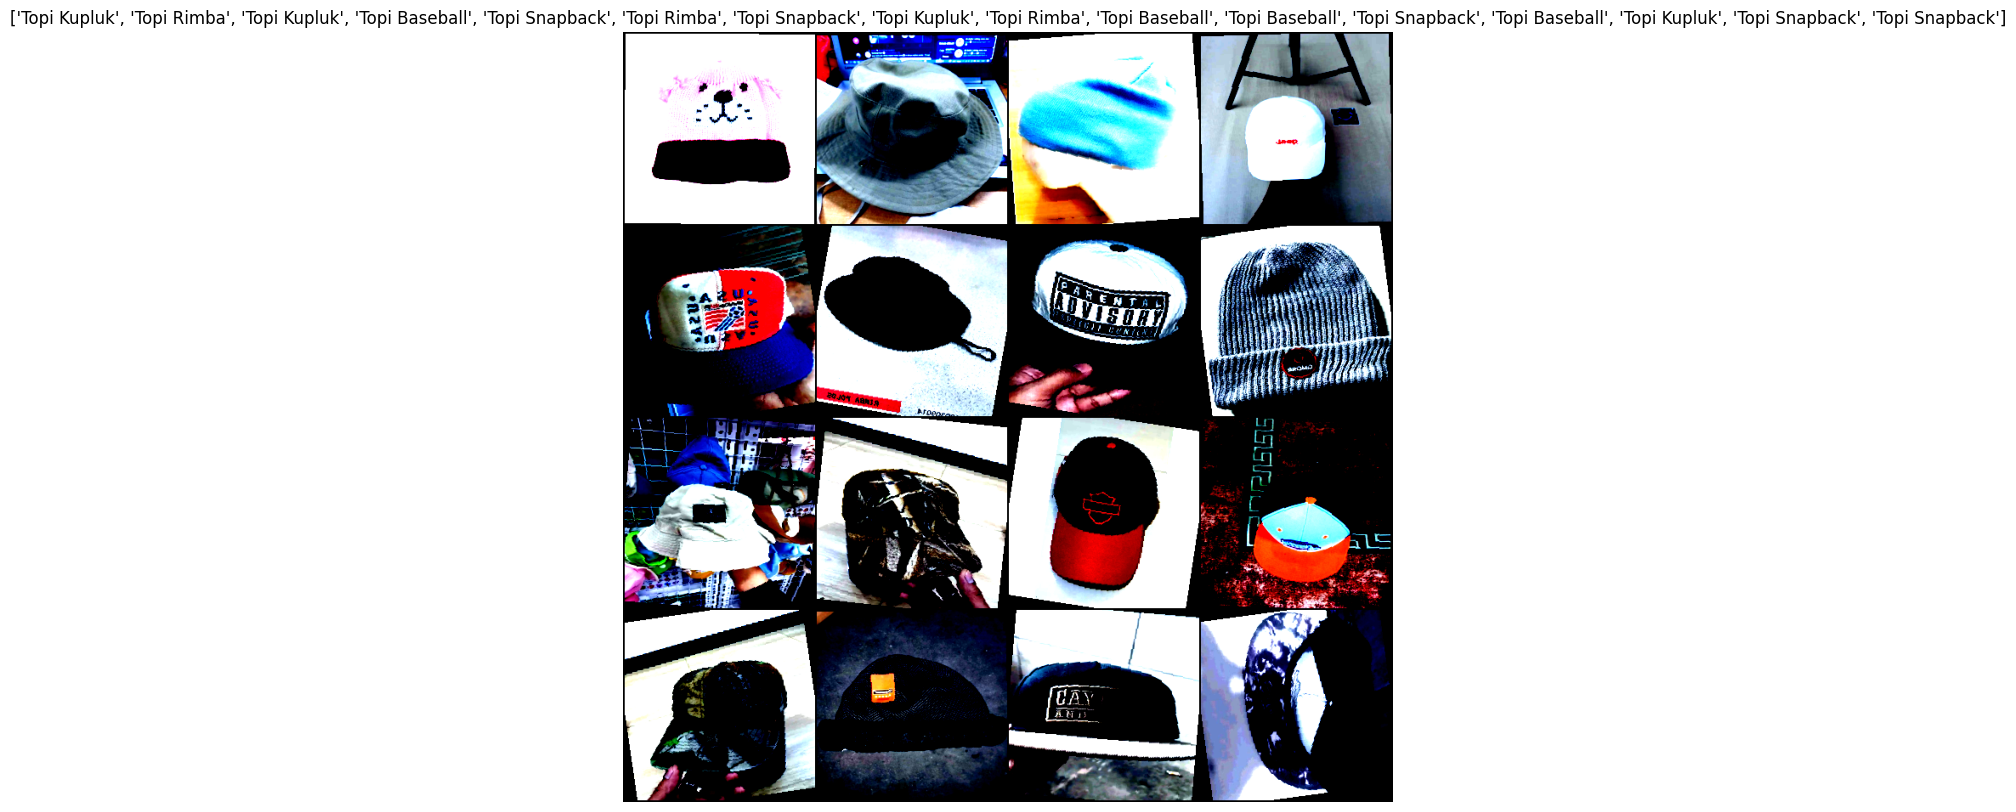

In [4]:

def show_batch(loader):
    images, labels = next(iter(loader))
    images = images[:16]
    labels = labels[:16]
    grid = make_grid(images, nrow=4)
    plt.figure(figsize=(10,10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title([class_names[i] for i in labels])
    plt.axis('off')
    plt.show()

show_batch(train_loader)


In [6]:
import torch
import torch.nn as nn
from torchvision import models
import os

# Pastikan device terdefinisi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inisialisasi model ResNet50 dan sesuaikan untuk 4 kelas
model = models.resnet50(weights=None)  # Tidak pakai pretrained karena hanya ingin simpan arsitektur
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # Ganti 4 dengan jumlah kelas kamu

# Pindahkan model ke device
model = model.to(device)

# Fungsi akurasi dan evaluasi
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

def evaluate(model, loader):
    model.eval()
    total_correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            total_correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return total_correct / total

# Simpan model ke Google Drive
os.makedirs('/content/drive/MyDrive/Models', exist_ok=True)
torch.save(model.state_dict(), '/content/drive/MyDrive/Models/model_resnet50.pth')
print("Model berhasil disimpan di Google Drive.")


Model berhasil disimpan di Google Drive.


In [7]:

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

epochs = 50

for epoch in range(epochs):
    # === TRAINING ===
    model.train()
    running_loss, running_corrects = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(outputs.argmax(1) == labels)

    train_loss = running_loss / train_size
    train_acc = running_corrects.double() / train_size

    # === VALIDATION ===
    model.eval()
    val_running_loss, val_running_corrects = 0.0, 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item() * val_inputs.size(0)
            val_running_corrects += torch.sum(val_outputs.argmax(1) == val_labels)

    val_loss = val_running_loss / val_size
    val_acc = val_running_corrects.double() / val_size

    # === Simpan history ===
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    # === Print format seperti yang kamu minta ===
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc * 100:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc * 100:.2f}%\n")


Epoch 1/50
Train Loss: 1.1753, Acc: 48.87%
Val Loss: 0.8506, Acc: 73.89%

Epoch 2/50
Train Loss: 0.7500, Acc: 75.21%
Val Loss: 0.7414, Acc: 75.56%

Epoch 3/50
Train Loss: 0.5900, Acc: 80.66%
Val Loss: 0.6084, Acc: 72.78%

Epoch 4/50
Train Loss: 0.5206, Acc: 84.70%
Val Loss: 0.5423, Acc: 81.11%

Epoch 5/50
Train Loss: 0.4277, Acc: 87.07%
Val Loss: 0.4994, Acc: 81.11%

Epoch 6/50
Train Loss: 0.4323, Acc: 85.65%
Val Loss: 0.5778, Acc: 80.00%

Epoch 7/50
Train Loss: 0.3887, Acc: 87.43%
Val Loss: 0.5192, Acc: 82.78%

Epoch 8/50
Train Loss: 0.3936, Acc: 87.43%
Val Loss: 0.4765, Acc: 84.44%

Epoch 9/50
Train Loss: 0.3539, Acc: 88.97%
Val Loss: 0.4734, Acc: 80.00%

Epoch 10/50
Train Loss: 0.3331, Acc: 88.97%
Val Loss: 0.5320, Acc: 77.78%

Epoch 11/50
Train Loss: 0.3353, Acc: 87.90%
Val Loss: 0.4385, Acc: 82.78%

Epoch 12/50
Train Loss: 0.2997, Acc: 90.51%
Val Loss: 0.4836, Acc: 83.33%

Epoch 13/50
Train Loss: 0.3167, Acc: 89.68%
Val Loss: 0.4172, Acc: 82.78%

Epoch 14/50
Train Loss: 0.2779, Ac

In [9]:
# --- Hitung akurasi test ---
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = correct_test / total_test
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")



✅ Test Accuracy: 86.81%



Test Accuracy: 88.46%


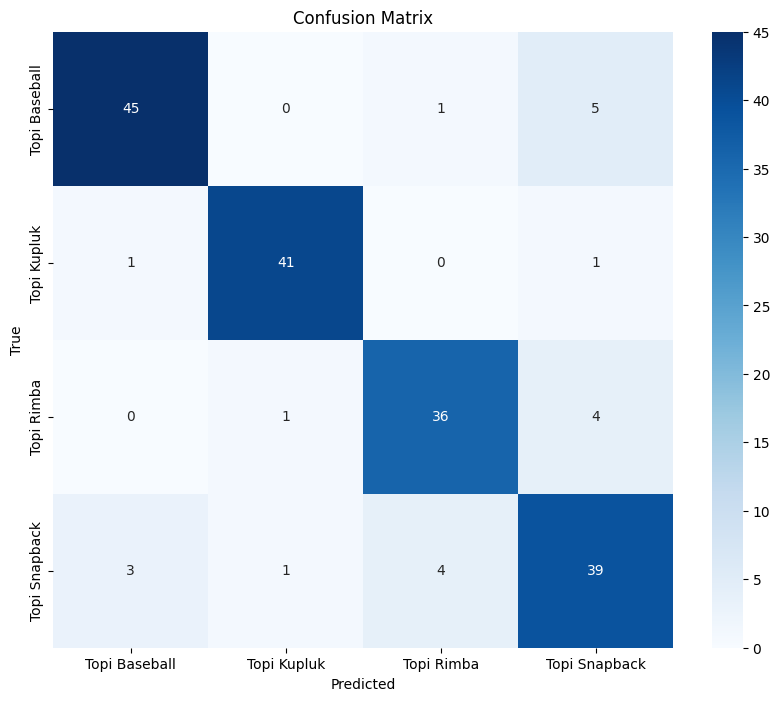


Classification Report:

               precision    recall  f1-score   support

Topi Baseball       0.92      0.88      0.90        51
  Topi Kupluk       0.95      0.95      0.95        43
   Topi Rimba       0.88      0.88      0.88        41
Topi Snapback       0.80      0.83      0.81        47

     accuracy                           0.88       182
    macro avg       0.89      0.89      0.89       182
 weighted avg       0.89      0.88      0.89       182



In [10]:
model.eval()
correct = 0
total = 0
y_true = []
y_pred = []

# Disable gradient calculation for validation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Prediksi kelas dengan nilai tertinggi
        _, preds = torch.max(outputs, 1)

        # Hitung akurasi
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Menyimpan prediksi dan label untuk analisis lebih lanjut
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Hitung akurasi test
test_acc = correct / total
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Tampilkan Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


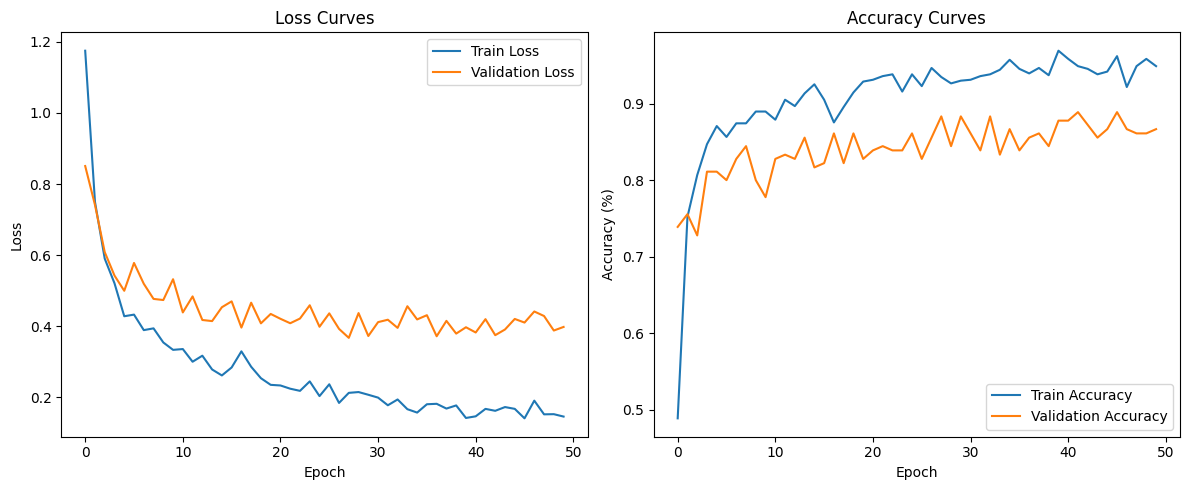

In [11]:
import matplotlib.pyplot as plt
import torch

# Konversi semua elemen ke CPU dan float
train_loss_hist = [x.cpu().item() if torch.is_tensor(x) else x for x in train_loss_hist]
val_loss_hist = [x.cpu().item() if torch.is_tensor(x) else x for x in val_loss_hist]
train_acc_hist = [x.cpu().item() if torch.is_tensor(x) else x for x in train_acc_hist]
val_acc_hist = [x.cpu().item() if torch.is_tensor(x) else x for x in val_acc_hist]

# Plot
plt.figure(figsize=(12, 5))

# Subplot untuk loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Subplot untuk akurasi
plt.subplot(1, 2, 2)
plt.plot(train_acc_hist, label='Train Accuracy')
plt.plot(val_acc_hist, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()



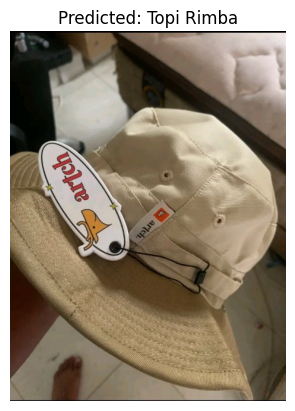

In [12]:

def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(img_t)
        _, pred = torch.max(outputs, 1)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[pred.item()]}")
    plt.axis('off')
    plt.show()

predict_image(df.sample(1)['image_path'].values[0])


In [17]:
from google.colab import files
uploaded = files.upload()


Saving model_resnet50.pth to model_resnet50.pth


Saving testopi.jpeg to testopi.jpeg


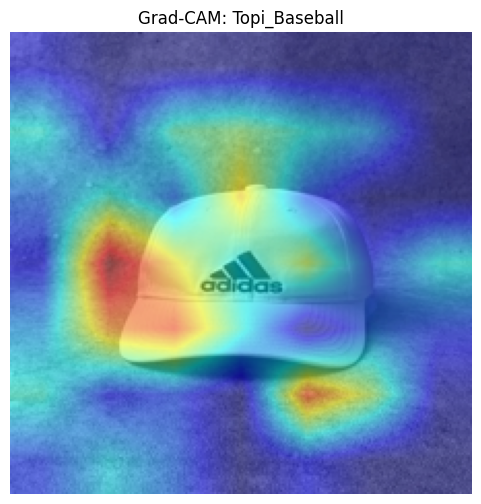

Predicted class: Topi_Baseball


In [22]:
# === Upload Gambar ===
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]  # otomatis pakai nama file yang diupload

# === Import Library ===
from PIL import Image
import torchvision.transforms as transforms
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

# === Setup Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load Model Hasil Training (ResNet50, 4 kelas) ===
import torchvision.models as models
model = models.resnet50(pretrained=False)  # GANTI KE RESNET50
num_ftrs = model.fc.in_features  # 2048 untuk resnet50
model.fc = torch.nn.Linear(num_ftrs, 4)  # 4 kelas topi
model.load_state_dict(torch.load("model_resnet50.pth", map_location=device))  # pastikan file ini ada
model = model.to(device)
model.eval()

# === Class Names ===
class_names = ['Topi_Baseball', 'Topi_Kupluk', 'Topi_Rimba', 'Topi_Snapback']

# === Preprocess Gambar ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# === Grad-CAM Function ===
def grad_cam(model, image_tensor, target_class):
    model.eval()
    gradients, activations = [], []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])
    def forward_hook(module, input, output):
        activations.append(output)

    final_conv = model.layer4[1]  # layer yang terakhir sebelum fc
    f_handle = final_conv.register_forward_hook(forward_hook)
    b_handle = final_conv.register_backward_hook(backward_hook)

    output = model(image_tensor)
    model.zero_grad()
    class_loss = output.squeeze(0)[target_class]
    class_loss.backward()

    grads = gradients[0].cpu().data.numpy()[0]
    acts = activations[0].cpu().data.numpy()[0]
    weights = np.mean(grads, axis=(1, 2))
    cam = np.zeros(acts.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * acts[i, :, :]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    f_handle.remove(); b_handle.remove()
    return cam

# === Prediksi dan Visualisasi Grad-CAM ===
output = model(input_tensor)
pred_class = output.argmax(1).item()
heatmap = grad_cam(model, input_tensor, pred_class)

if heatmap is not None:
    img_np = np.array(img.resize((224,224)))[:, :, ::-1]  # RGB ke BGR
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlayed_img = cv2.addWeighted(img_np, 0.5, heatmap_colored, 0.5, 0)

    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))  # BGR ke RGB
    plt.title(f"Grad-CAM: {class_names[pred_class]}")
    plt.axis('off')
    plt.show()

    print("Predicted class:", class_names[pred_class])
else:
    print("Grad-CAM gagal dihitung.")
